# PREDIKSI BERAS, DAGING AYAM, DAN DAGING SAPI BULAN JANUARI TAHUN 2024 DENGAN LSTM DAN LINEAR REGRESSION

 **KELOMPOK 8**
 - Aziizah Oki Shofrina -	2109106004
 - Agustina Dwi - 2109106037
 - Ayu Lestari - 2109106054

**Metode : LSTM & LINEAR REGRESSION**

**DATASET: DARI WEBSITE https://www.bi.go.id/hargapangan,
DATASET SUDAH TERUNDUH: https://docs.google.com/spreadsheets/d/1NqoR0mOUsycpNjfXVQGLMr_sEgT7HNSq/edit?usp=sharing&ouid=107736077997358769705&rtpof=true&sd=true**

**TUJUAN: Prediksi harga pangan 1 bulan kedepan dari beras, daging ayam, dan daging sapi**

pada percobaan ini antara data beras, data daging ayam, dan data daging sapi, kami asumsikan tidak memiliki keterkaitan satu sama lain.

# Import Library

In [ ]:
import pandas as pd # untuk mengakses dan memodifikasi file dataset
import numpy as np # untuk melakukan komputasi numerik yang efisien
import matplotlib.pyplot as plt # untuk menampilkan visualisasi data

from google.colab import drive # untuk mengakses dataset pada google drive
from sklearn.linear_model import LinearRegression # untuk mengakses metode Linear Regression
from keras.models import Sequential # untuk mengakses fungsi model neural network sekuensial
from keras.layers import LSTM, Dense # Untuk Menambahkan ke dalam model neural network
from sklearn.preprocessing import MinMaxScaler # untuk melakukan normalisasi dengan min max scaler
from sklearn.metrics import mean_squared_error # untuk menghitung nilai error pada model

#Akses dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/ML UAS/

/content/drive/My Drive/ML UAS


In [ ]:
data2021_2023=pd.read_excel("Tabel Harga Berdasarkan Daerah_2021-2023.xlsx")
data2021_2023[:5]

,No,Komoditas (Rp),01/ 01/ 2021,04/ 01/ 2021,05/ 01/ 2021,06/ 01/ 2021,07/ 01/ 2021,08/ 01/ 2021,11/ 01/ 2021,12/ 01/ 2021,...,18/ 09/ 2023,19/ 09/ 2023,20/ 09/ 2023,21/ 09/ 2023,22/ 09/ 2023,25/ 09/ 2023,26/ 09/ 2023,27/ 09/ 2023,28/ 09/ 2023,29/ 09/ 2023
0,I,Beras,-,"11,800","11,800","11,800","11,800","11,800","11,800","11,800",...,"14,200","14,250","14,250","14,250","14,300","14,350","14,350","14,350","14,400","14,400"
1,1,Beras Kualitas Bawah I,-,"10,750","10,850","10,800","10,800","10,800","10,800","10,800",...,"13,050","13,100","13,100","13,150","13,150","13,200","13,250","13,250","13,250","13,300"
2,2,Beras Kualitas Bawah II,-,"10,400","10,450","10,450","10,450","10,450","10,450","10,450",...,"12,850","12,900","12,900","12,900","12,950","13,000","13,000","13,000","13,100","13,050"
3,3,Beras Kualitas Medium I,-,"11,800","11,800","11,850","11,800","11,800","11,800","11,800",...,"14,250","14,300","14,300","14,300","14,350","14,350","14,400","14,400","14,350","14,400"
4,4,Beras Kualitas Medium II,-,"11,650","11,600","11,650","11,650","11,650","11,650","11,650",...,"14,000","14,100","14,100","14,100","14,150","14,200","14,200","14,200","14,150","14,250"


# Preprocessing

In [ ]:
#mengganti data dengan harga "-" dengan harga pada hari setelahnya
def replace_empty(data):
  data_columns=data.index.tolist()
  data_index=data.index[data=="-"]
  if(len(data_index)!=0):
    value_next=[data_columns.index(i)+1 for i in data_index]
    data[data_index]=data[[data_columns[x] for x in value_next]]
    replace_empty(data)
  return data

#mengganti koma menjadi titik lalu mengubah data string menjadi float
def replace_char(data):
  data_columns=data.index.tolist()
  # x=[name.replace(" ","").replace("/2021","") for name in data_columns] #ubah nama kolom sementara
  for col in data_columns:
    data[col]=data[col].replace(',', '.')
  data=data.astype(float)
  return data

#ubah tanggal menjadi integer
def to_integer(dt_time):
    return [x.timestamp() for x in dt_time]

def inverse_scale(prediction,y_,scaler):
  data_predict=np.array([[0.0,float(prediction[i])] for i in range(len(prediction))])
  data_predict_real=np.array([[0.0,float(y_[i])] for i in range(len(y_))])
  return scaler.inverse_transform(data_predict),scaler.inverse_transform(data_predict_real)

## Menghapus kolom yang tidak perlu

In [ ]:
data_kategori=data2021_2023["Komoditas (Rp)"]
data=data2021_2023.drop(["No","Komoditas (Rp)"],axis=1)
print("Kategori:\n",data_kategori)

Kategori:
 0                        Beras
1       Beras Kualitas Bawah I
2      Beras Kualitas Bawah II
3      Beras Kualitas Medium I
4     Beras Kualitas Medium II
5       Beras Kualitas Super I
6      Beras Kualitas Super II
7                  Daging Ayam
8        Daging Ayam Ras Segar
9                  Daging Sapi
10      Daging Sapi Kualitas 1
11      Daging Sapi Kualitas 2
Name: Komoditas (Rp), dtype: object


##  visualisasi data

In [ ]:
def preprocessing_data(data):
  data_beras=replace_empty(data.iloc[0])
  data_beras=replace_char(data_beras)
  data_ayam=replace_empty(data.iloc[7])
  data_ayam=replace_char(data_ayam)
  data_sapi=replace_empty(data.iloc[9])
  data_sapi=replace_char(data_sapi)

  return data_beras,data_ayam,data_sapi

#menampilkan visualisasi data beserta batas nilai extreme (threshold)
def visualisation(data_beras,data_ayam,data_sapi,threshold):
  fig,ax=plt.subplots(ncols=1,nrows=3,figsize=(30,25))
  #menampilkan data
  ax[0].plot(data_beras,'o-')
  #menampilkan garis batas nilai extreme
  if (len(threshold)!=0):
    ax[0].axhline(threshold[0], color='r')
    ax[0].axhline(threshold[1], color='r')
    ax[0].set_xticks([])
    ax[0].margins(x=0)
    ax[0].set_title("BERAS")

  #menampilkan data
  ax[1].plot(data_ayam,'o-')
  #menampilkan garis batas nilai extreme
  if (len(threshold)!=0):
    ax[1].axhline(threshold[2], color='r')
    ax[1].axhline(threshold[3], color='r')
    ax[1].set_xticks([])
    ax[1].margins(x=0)
    ax[1].set_title("Daging Ayam")

  #menampilkan data
  ax[2].plot(data_sapi,'o-')
  #menampilkan garis batas nilai extreme
  if (len(threshold)!=0):
    ax[2].axhline(threshold[4], color='r')
    ax[2].axhline(threshold[5], color='r')
    ax[2].set_xticks([])
    ax[2].margins(x=0)
    ax[2].set_title("Daging Sapi")

  plt.show()

kami tetapkan batas terendah harga beras yaitu 11.500 dan tertinggi yaitu 14.500

kami tetapkan batas terendah harga daging ayam yaitu 32.000 dan tertinggi yaitu 41.000

kami tetapkan batas terendah harga daging sapi yaitu 116.000 dan tertinggi yaitu 138.000

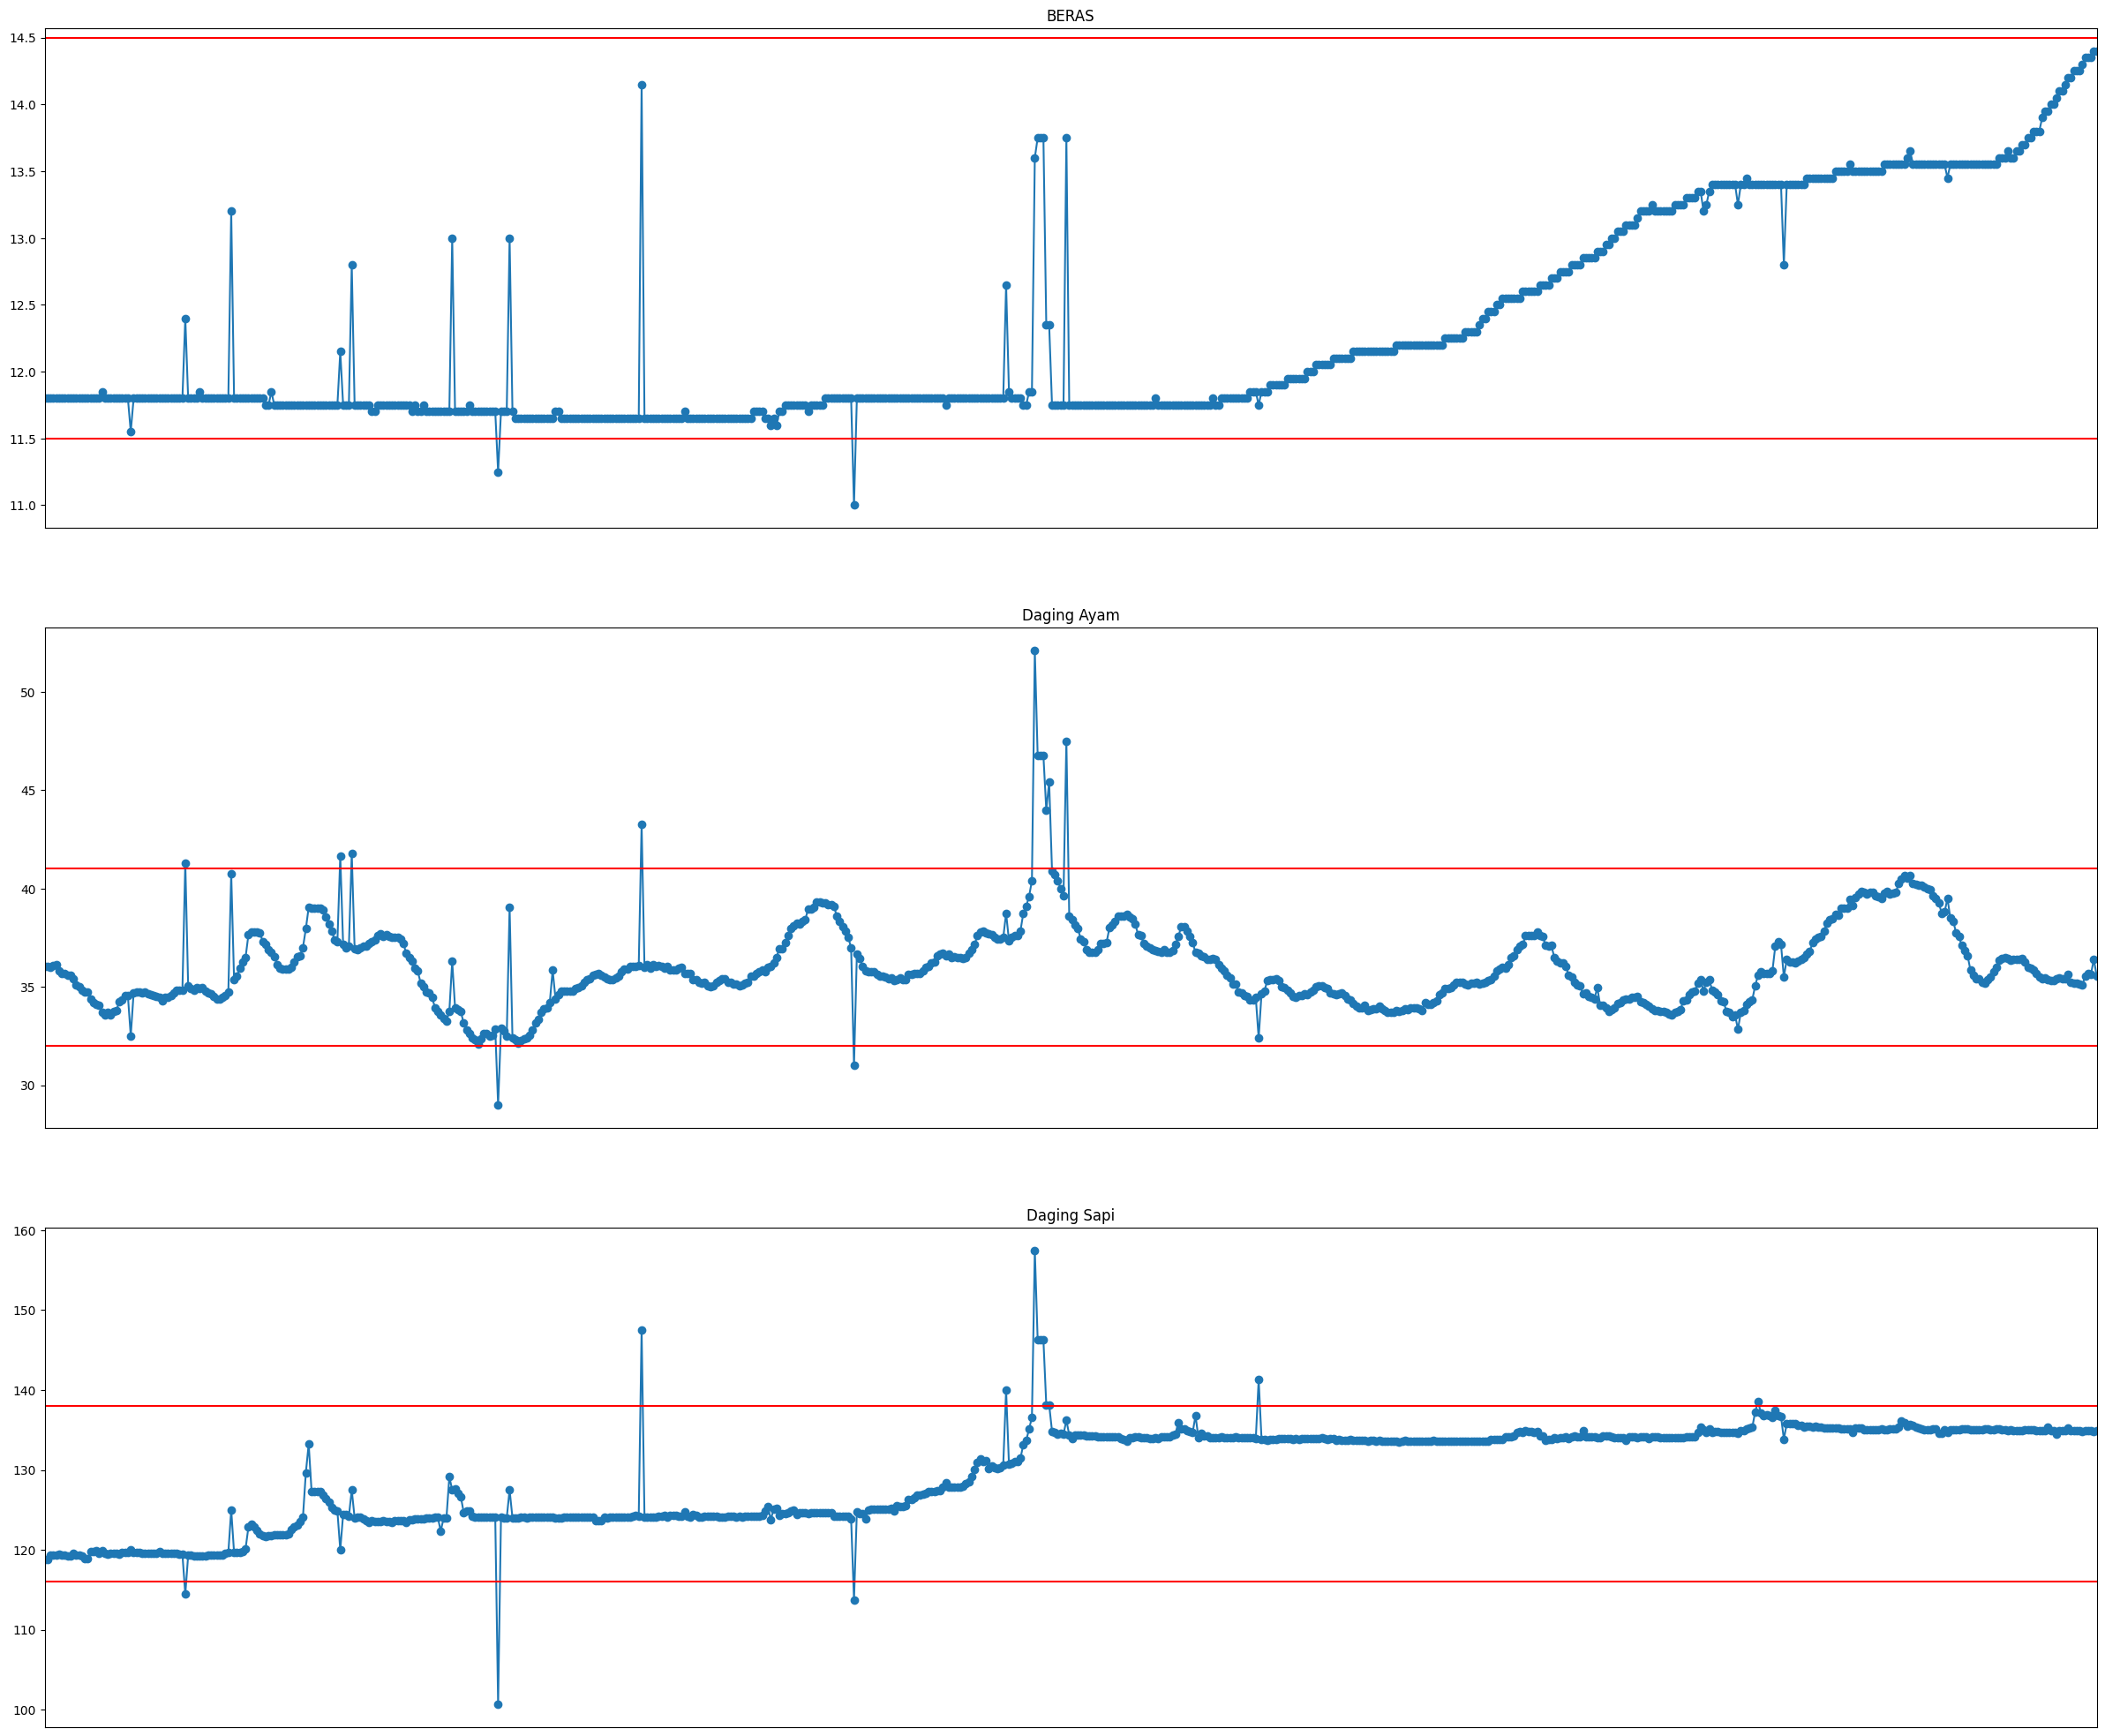

In [ ]:
threshold=[11.5,14.5,32,41,116,138]

data_beras,data_ayam,data_sapi=preprocessing_data(data)
visualisation(data_beras,data_ayam,data_sapi,threshold)

# TRAIN TEST SPLIT

In [ ]:
def split(data):
  train_size = int(len(data) * 0.8)
  return data[0:train_size,:], data[train_size:len(data),:]

# Nilai extreme
Nilai terlalu rendah atau terlalu tinggi dari threshold

In [ ]:
Extreme_low_beras=data_beras.index[data_beras<threshold[0]]
Extreme_high_beras=data_beras.index[data_beras>threshold[1]]

Extreme_low_ayam=data_ayam.index[data_ayam<threshold[2]]
Extreme_high_ayam=data_ayam.index[data_ayam>threshold[3]]

Extreme_low_sapi=data_sapi.index[data_sapi<threshold[4]]
Extreme_high_sapi=data_sapi.index[data_sapi>threshold[5]]

In [ ]:
print("beras\nlow ",Extreme_low_beras.tolist(),'\nhigh ',Extreme_high_beras.tolist())
print("")
print("ayam \nlow ",Extreme_low_ayam.tolist(),'\nhigh ',Extreme_high_ayam.tolist())
print("")
print("sapi \nlow ",Extreme_low_sapi.tolist(),'\nhigh ',Extreme_high_sapi.tolist())

beras
low  ['11/ 08/ 2021', '01/ 02/ 2022'] 
high  []

ayam 
low  ['11/ 08/ 2021', '01/ 02/ 2022'] 
high  ['11/ 03/ 2021', '26/ 05/ 2021', '01/ 06/ 2021', '20/ 10/ 2021', '29/ 04/ 2022', '02/ 05/ 2022', '03/ 05/ 2022', '04/ 05/ 2022', '05/ 05/ 2022', '06/ 05/ 2022', '16/ 05/ 2022']

sapi 
low  ['11/ 03/ 2021', '11/ 08/ 2021', '01/ 02/ 2022'] 
high  ['20/ 10/ 2021', '15/ 04/ 2022', '29/ 04/ 2022', '02/ 05/ 2022', '03/ 05/ 2022', '04/ 05/ 2022', '05/ 05/ 2022', '06/ 05/ 2022', '17/ 08/ 2022', '18/ 04/ 2023']


terlihat bahwa tidak terdapat trend dimana pada hari tertentu di tahun yang berbeda mengalami kenaikan. Sehingga data extreme kami turunkan/naikan ke nilai thresholdnya

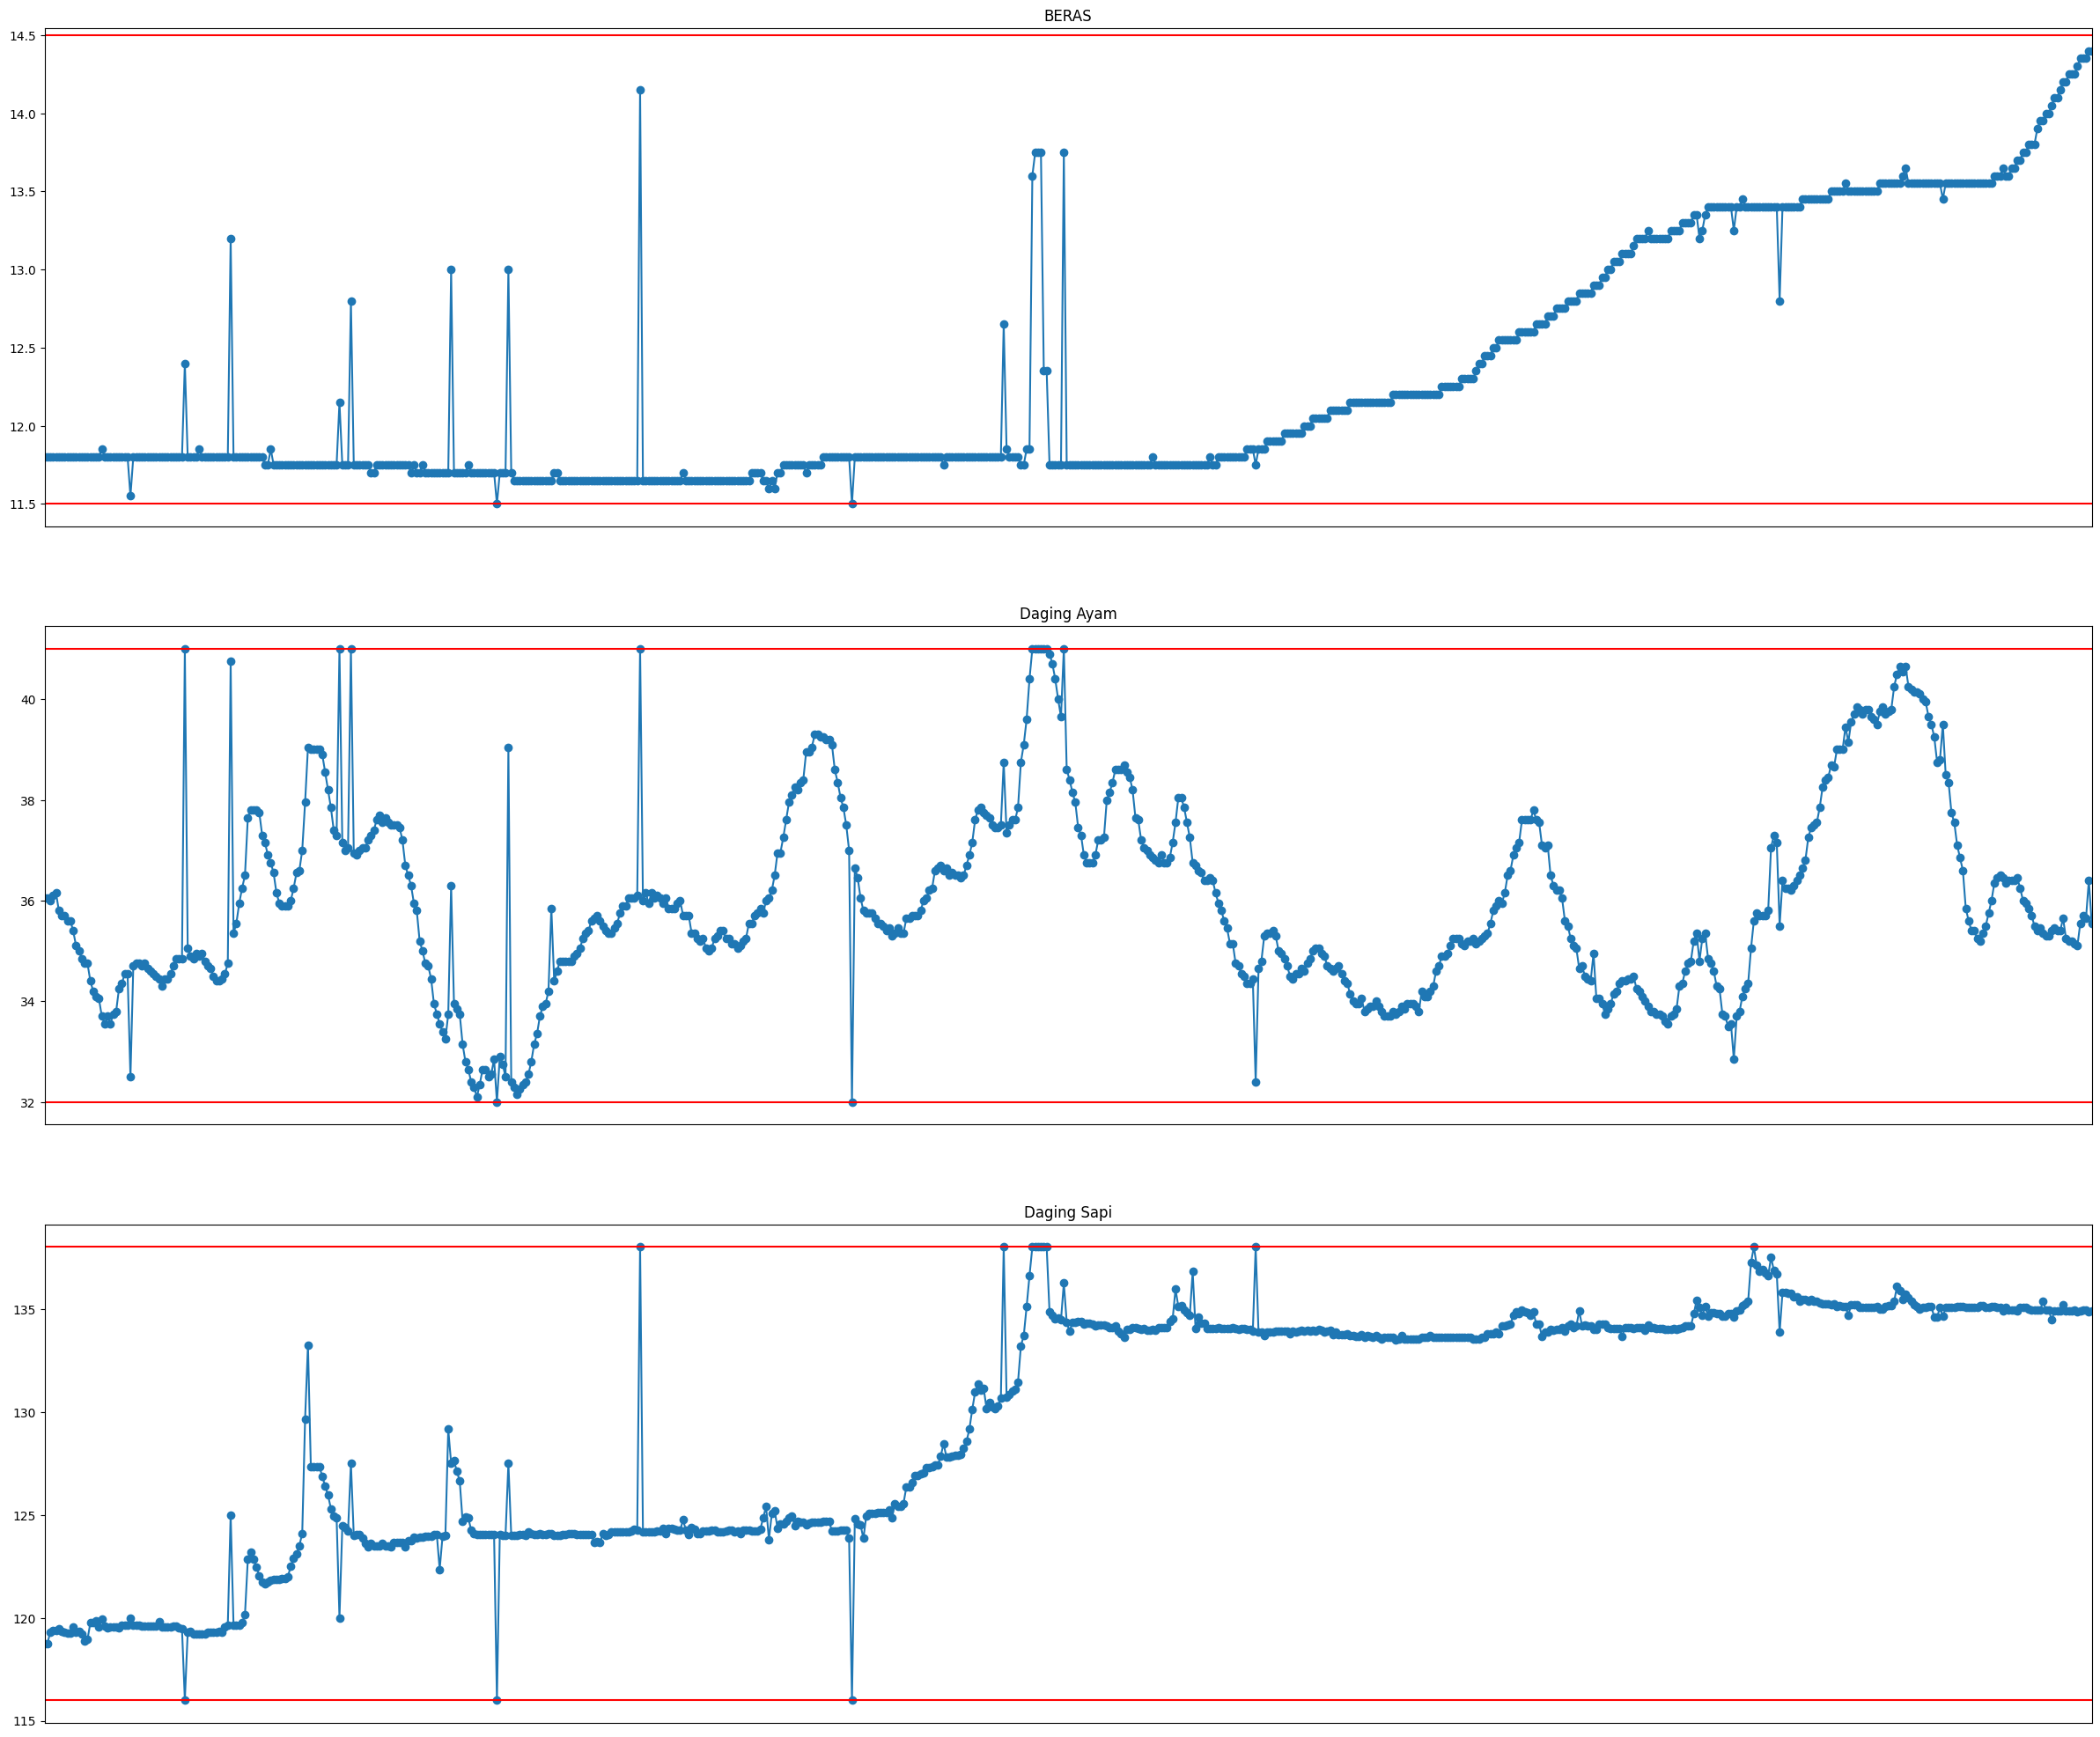

In [ ]:
data_beras[Extreme_low_beras]=threshold[0]
data_beras[Extreme_high_beras]=threshold[1]

data_ayam[Extreme_low_ayam]=threshold[2]
data_ayam[Extreme_high_ayam]=threshold[3]

data_sapi[Extreme_low_sapi]=threshold[4]
data_sapi[Extreme_high_sapi]=threshold[5]

visualisation(data_beras,data_ayam,data_sapi,threshold)

## Disimpulkan
### -DATA
Terlihat bahwa data beras memiliki kenaikan hampir linear pada tahun 2022-2023 sehingga untuk memprediksi tahun setelahnya, data tahun 2021 tidak kami pakai.

Data daging sapi dan daging ayam kami tetap gunakan semua data asli.


### -ALGORITMA

Karena bentuk data beras dan daging sapi hampir linear maka kami menggunakan algoritma Linear Regression.

Sedangkan untuk data daging ayam digunakan algoritma LSTM

# Perubahan Data

In [ ]:
index_beras_2022=data_beras.index.tolist().index('01/ 07/ 2022')
# index_sapi_2022=data_sapi.index.tolist().index('03/ 01/ 2022')
data_beras22_23=data_beras[index_beras_2022:]
# data_sapi22_23=data_sapi[index_sapi_2022:]

# LSTM

Epoch 1/20
58/58 [==============================] - 5s 4ms/step - loss: 0.1594
Epoch 2/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0537
Epoch 3/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0449
Epoch 4/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0438
Epoch 5/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 6/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0421
Epoch 7/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0417
Epoch 8/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0416
Epoch 9/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0412
Epoch 10/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0410
Epoch 11/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0410
Epoch 12/20
58/58 [==============================] - 0s 4ms/step - loss: 0.0408
Epoch 13/20
58/58 [==============================

<ipython-input-249-e430cca2bb83>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict=np.array([[0.0,float(prediction[i])] for i in range(len(prediction))])
<ipython-input-249-e430cca2bb83>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict=np.array([[0.0,float(prediction[i])] for i in range(len(prediction))])


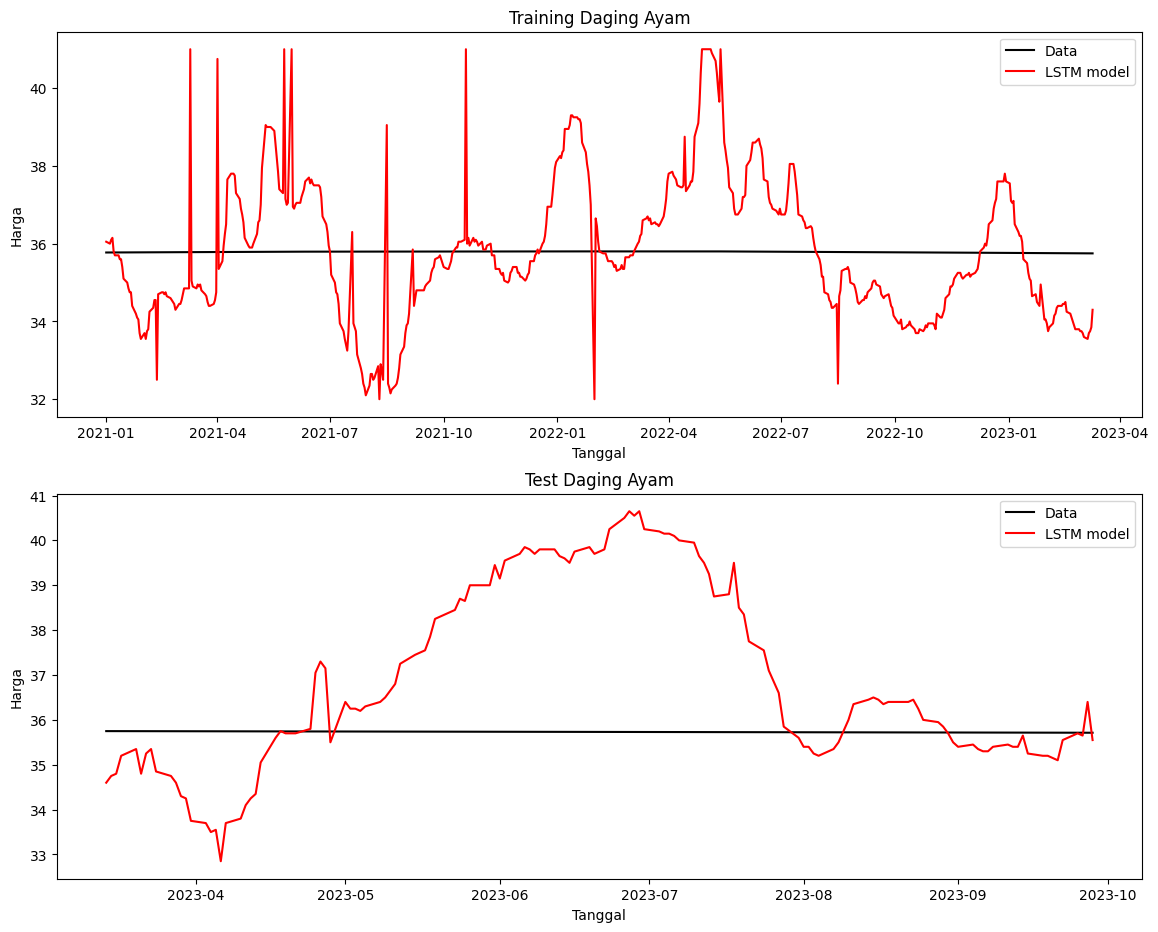


Train Score: 0.20 RMSE
Test Score: 0.26 RMSE


In [ ]:
date=pd.to_datetime( data_ayam.index.tolist(),format="%d/ %m/ %Y" )
data=pd.DataFrame(to_integer(date))
data["harga"]=data_ayam.values
#Normalisasi dengan Min Max Scalling

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.values)

train_data, test_data = split(data)

# Menyiapkan sequence output input
def create_sequences(data, sequence_length):
    X,y=[],[]
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length,0])
        y.append(data[i+sequence_length,1])
    return np.array(X), np.array(y)

sequence_length = 1
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test= create_sequences(test_data, sequence_length)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train, y_train, epochs=20, batch_size=10)

#hasil prediksi dengan data train
prediction_train=model_lstm.predict(X_train)
data_reverse,data_reverse_predict = inverse_scale(prediction_train,y_train,scaler)

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(14,11))

ax[0].plot(date[:len(X_train)].date, data_reverse[:,1], color= 'black', label= 'Data')
ax[0].plot(date[:len(X_train)].date,data_reverse_predict[:,1], color= 'red', label= 'LSTM model')
ax[0].set_xlabel("Tanggal")
ax[0].set_ylabel("Harga")
ax[0].set_title("Training Daging Ayam")
ax[0].legend()

#hasil prediksi dengan data train
test_lstm_prediction=model_lstm.predict(X_test)
data_reverse,data_reverse_predict = inverse_scale(test_lstm_prediction,y_test,scaler)

ax[1].plot(date[len(X_train)+1:-1].date, data_reverse[:,1], color= 'black', label= 'Data')
ax[1].plot(date[len(X_train)+1:-1].date,data_reverse_predict[:,1], color= 'red', label= 'LSTM model')
ax[1].set_xlabel("Tanggal")
ax[1].set_ylabel("Harga")
ax[1].set_title("Test Daging Ayam")

ax[1].legend()

plt.show()

#Mean Squared Error
trainScore = np.sqrt(mean_squared_error(y_train[:], prediction_train[:]))
print('\nTrain Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:], test_lstm_prediction[:]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 61ms/step


<ipython-input-276-ad87c145edfe>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_reverse_prediksi_ayam = scaler.inverse_transform([[0,float(prediksi_ayam[i])] for i in range(31)])


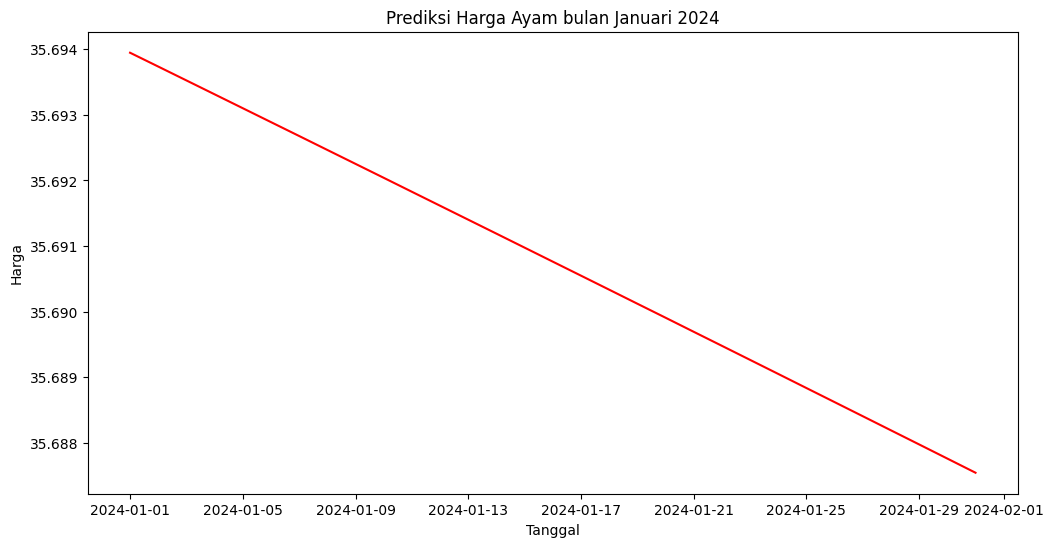

In [ ]:
day=31
predict_dates=pd.date_range(start='2024-01-01', periods=day)
predict_scaler=scaler.transform([[to_integer(predict_dates)[i],0] for i in range(31)])

prediksi_ayam= model_lstm.predict([[i] for i in predict_scaler[:,0]])
data_reverse_prediksi_ayam = scaler.inverse_transform([[0,float(prediksi_ayam[i])] for i in range(31)])

plt.figure(figsize = (12,6))
plt.plot(predict_dates.date,data_reverse_prediksi_ayam[:,1], color= 'red')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title("Prediksi Harga Ayam bulan Januari 2024")
plt.show()

In [ ]:
for i in range(day):
  print(f"{predict_dates.date[i]}: {data_reverse_prediksi_ayam[i,1]}" )

2024-01-01: 35.6939457654953
2024-01-02: 35.69373494386673
2024-01-03: 35.693523585796356
2024-01-04: 35.69331195950508
2024-01-05: 35.693100333213806
2024-01-06: 35.69288843870163
2024-01-07: 35.692676812410355
2024-01-08: 35.692464381456375
2024-01-09: 35.6922522187233
2024-01-10: 35.69204005599022
2024-01-11: 35.69182708859444
2024-01-12: 35.691614389419556
2024-01-13: 35.691401690244675
2024-01-14: 35.691188991069794
2024-01-15: 35.69097575545311
2024-01-16: 35.690762251615524
2024-01-17: 35.69054901599884
2024-01-18: 35.690335512161255
2024-01-19: 35.69012147188187
2024-01-20: 35.68990823626518
2024-01-21: 35.68969365954399
2024-01-22: 35.689479887485504
2024-01-23: 35.689265578985214
2024-01-24: 35.689051270484924
2024-01-25: 35.68883642554283
2024-01-26: 35.68862184882164
2024-01-27: 35.68840700387955
2024-01-28: 35.68819189071655
2024-01-29: 35.68797704577446
2024-01-30: 35.687761664390564
2024-01-31: 35.68754601478577


# Linear Regression

## Beras

<ipython-input-249-e430cca2bb83>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict=np.array([[0.0,float(prediction[i])] for i in range(len(prediction))])
<ipython-input-249-e430cca2bb83>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict_real=np.array([[0.0,float(y_[i])] for i in range(len(y_))])
<ipython-input-249-e430cca2bb83>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict=np.array([[0.0,float(prediction[i])] for i in rang

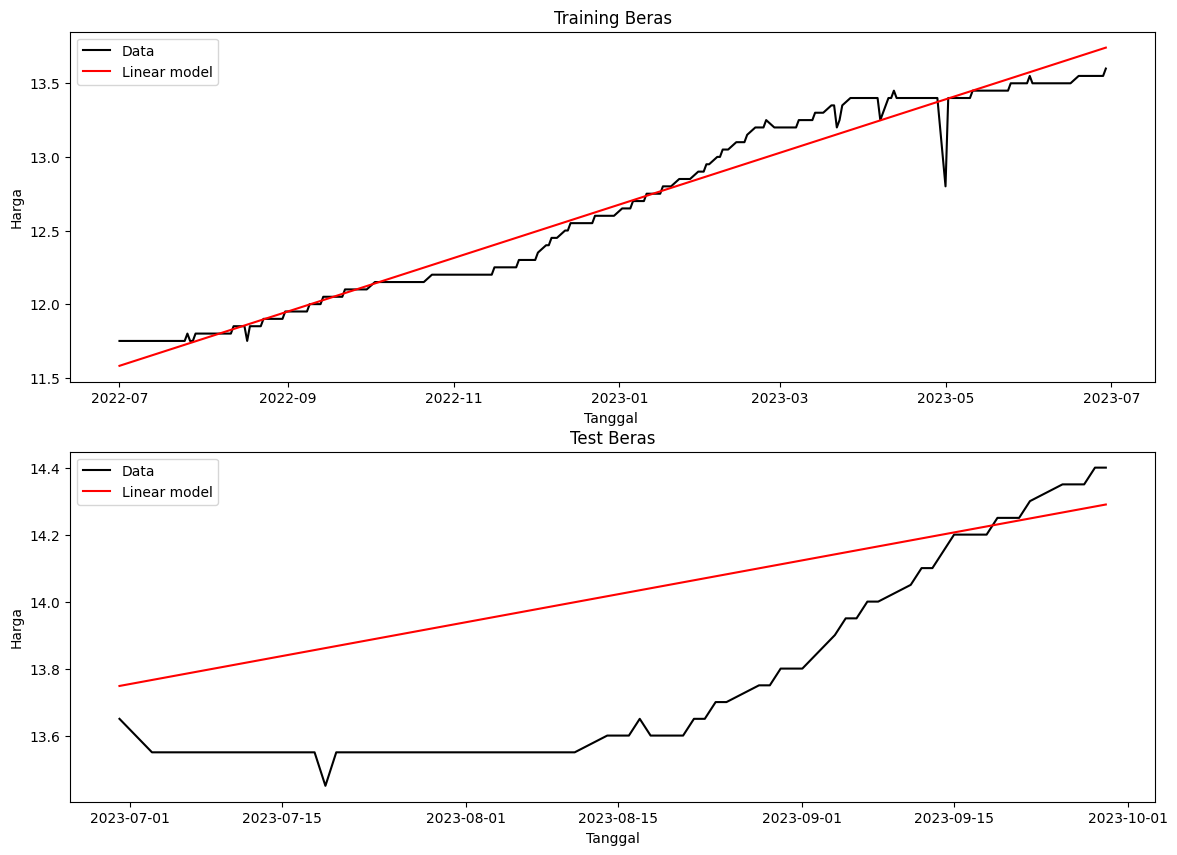


Train Score: 0.08 RMSE
Test Score: 0.21 RMSE


In [ ]:
org_dates=pd.to_datetime( data_beras22_23.index.tolist(),format="%d/ %m/ %Y" )
dates = to_integer(org_dates)
prices = data_beras22_23.values

#normalisasi minmaxscalling
scale=MinMaxScaler(feature_range=(0, 1))
transform=scale.fit_transform([[dates[i],prices[i]] for i in range(len(prices))])

trainx_data, testx_data =split(np.array([[x] for x in transform[:,0]]))
trainy_data, testy_data =split(np.array([[x] for x in transform[:,1]]))

model = LinearRegression()
model.fit(trainx_data, trainy_data)

prediksi_train_beras=model.predict(trainx_data)
prediksi_test_beras=model.predict(testx_data)

#inverse normalisasi
prediksi_train_beras,trainy_data=inverse_scale(prediksi_train_beras,trainy_data,scale)
prediksi_test_beras,testy_data=inverse_scale(prediksi_test_beras,testy_data,scale)

fig,ax1=plt.subplots(nrows=2,ncols=1,figsize=(14,10))

#training
ax1[0].plot(org_dates[:len(trainy_data)].date,trainy_data[:,1], color= 'black', label= "Data")
ax1[0].plot(org_dates[:len(trainy_data)].date,prediksi_train_beras[:,1], color= 'red', label= "Linear model")
ax1[0].set_xlabel("Tanggal ")
ax1[0].set_title("Training Beras")
ax1[0].set_ylabel("Harga")
ax1[0].legend()

# #testing
ax1[1].plot(org_dates[len(trainy_data):].date,testy_data[:,1], color= 'black', label= 'Data')
ax1[1].plot(org_dates[len(trainy_data):].date,prediksi_test_beras[:,1], color= 'red', label= 'Linear model')
ax1[1].set_xlabel("Tanggal")
ax1[1].set_ylabel("Harga")
ax1[1].set_title("Test Beras")
ax1[1].legend()

plt.show()

#Mean Squared Error
trainScore = np.sqrt(mean_squared_error(trainy_data[:], prediksi_train_beras[:]))
print('\nTrain Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testy_data[:], prediksi_test_beras[:]))
print('Test Score: %.2f RMSE' % (testScore))

<ipython-input-262-0e81a8a5190b>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediksi_hasil=scale.inverse_transform([[0,float(prediksi_beras[i])] for i in range(31)])


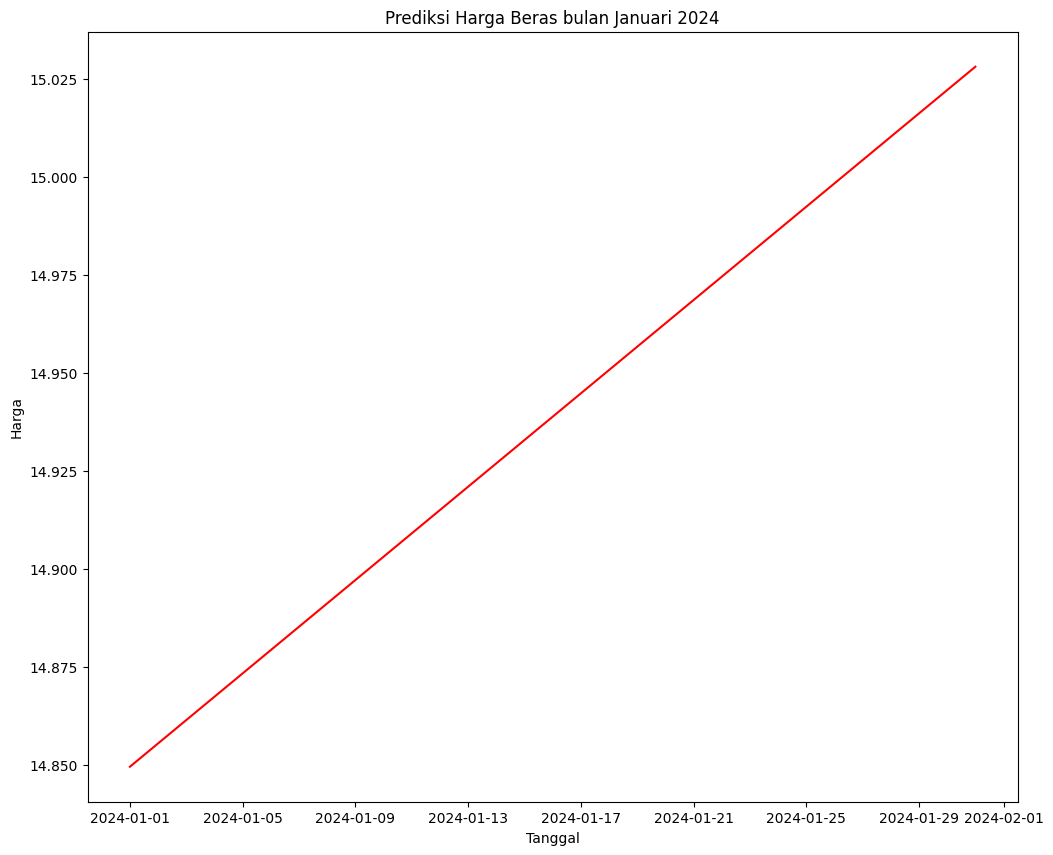

In [ ]:
day=31
predict_dates=pd.date_range(start='2024-01-01', periods=day)
dates_scale=scale.transform([[to_integer(predict_dates)[i],0] for i in range(31)])

prediksi_beras= model.predict([[i] for i  in dates_scale[:,0]])
prediksi_hasil=scale.inverse_transform([[0,float(prediksi_beras[i])] for i in range(31)])

plt.figure(figsize = (12,10))
plt.plot(predict_dates.date,prediksi_hasil[:,1], color= 'red')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title("Prediksi Harga Beras bulan Januari 2024")
plt.show()

In [ ]:
for i in range(day):
  print(f"{predict_dates.date[i]}: {prediksi_hasil[i,1]}" )

2024-01-01: 14.849527906524886
2024-01-02: 14.855481396846033
2024-01-03: 14.8614348871672
2024-01-04: 14.867388377488346
2024-01-05: 14.873341867809513
2024-01-06: 14.879295358130662
2024-01-07: 14.885248848451829
2024-01-08: 14.891202338772976
2024-01-09: 14.897155829094142
2024-01-10: 14.90310931941529
2024-01-11: 14.909062809736456
2024-01-12: 14.915016300057603
2024-01-13: 14.92096979037877
2024-01-14: 14.926923280699919
2024-01-15: 14.932876771021085
2024-01-16: 14.938830261342233
2024-01-17: 14.9447837516634
2024-01-18: 14.950737241984546
2024-01-19: 14.956690732305713
2024-01-20: 14.962644222626862
2024-01-21: 14.968597712948029
2024-01-22: 14.974551203269176
2024-01-23: 14.980504693590342
2024-01-24: 14.98645818391149
2024-01-25: 14.992411674232656
2024-01-26: 14.998365164553805
2024-01-27: 15.004318654874972
2024-01-28: 15.010272145196119
2024-01-29: 15.016225635517285
2024-01-30: 15.022179125838433
2024-01-31: 15.0281326161596


## Daging Sapi

<ipython-input-249-e430cca2bb83>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict=np.array([[0.0,float(prediction[i])] for i in range(len(prediction))])
<ipython-input-249-e430cca2bb83>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict_real=np.array([[0.0,float(y_[i])] for i in range(len(y_))])
<ipython-input-249-e430cca2bb83>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_predict=np.array([[0.0,float(prediction[i])] for i in rang

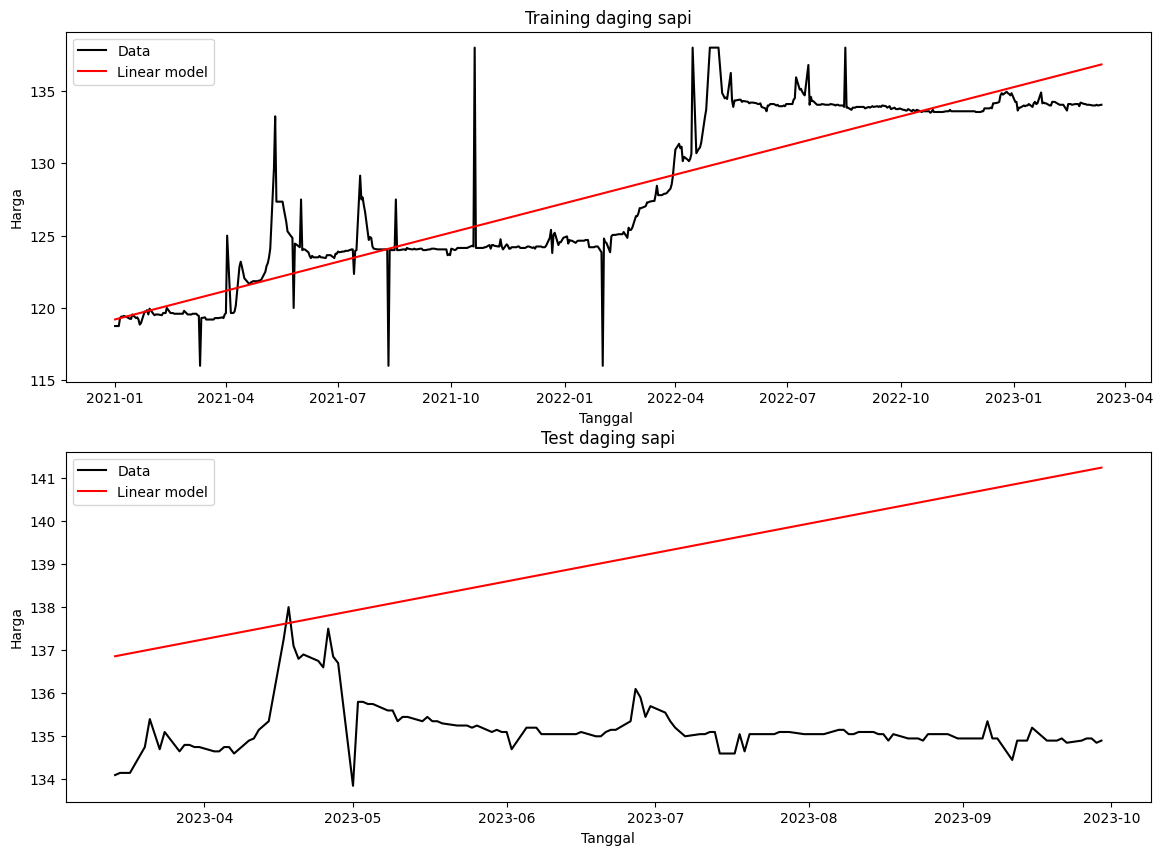


Train Score: 1.73 RMSE
Test Score: 2.94 RMSE


In [ ]:
org_dates=pd.to_datetime( data_sapi.index.tolist(),format="%d/ %m/ %Y" )
dates = to_integer(org_dates)
prices = data_sapi.values

#normalisasi minmaxscalling
scale=MinMaxScaler(feature_range=(0, 1))
transform=scale.fit_transform([[float(dates[i]),prices[i]] for i in range(len(prices))])

trainx_data, testx_data =split(np.array([[x] for x in transform[:,0]]))
trainy_data, testy_data =split(np.array([[x] for x in transform[:,1]]))

model = LinearRegression()
model.fit(trainx_data, trainy_data)

prediksi_train_sapi=model.predict(trainx_data)
prediksi_test_sapi=model.predict(testx_data)

#inverse normalisasi
prediksi_train_sapi,trainy_data=inverse_scale(prediksi_train_sapi,trainy_data,scale)
prediksi_test_sapi,testy_data=inverse_scale(prediksi_test_sapi,testy_data,scale)

fig,ax1=plt.subplots(nrows=2,ncols=1,figsize=(14,10))

#training
ax1[0].plot(org_dates[:len(trainy_data)].date,trainy_data[:,1], color= 'black', label= "Data")
ax1[0].plot(org_dates[:len(trainy_data)].date,prediksi_train_sapi[:,1], color= 'red', label= "Linear model")
ax1[0].set_xlabel("Tanggal ")
ax1[0].set_title("Training daging sapi")
ax1[0].set_ylabel("Harga")
ax1[0].legend()

#testing
ax1[1].plot(org_dates[len(trainy_data):].date,testy_data[:,1], color= 'black', label= 'Data')
ax1[1].plot(org_dates[len(trainy_data):].date,prediksi_test_sapi[:,1], color= 'red', label= 'Linear model')
ax1[1].set_xlabel("Tanggal")
ax1[1].set_ylabel("Harga")
ax1[1].set_title("Test daging sapi")
ax1[1].legend()

plt.show()

#Mean Squared Error
trainScore = np.sqrt(mean_squared_error(trainy_data[:], prediksi_train_sapi[:]))
print('\nTrain Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testy_data[:], prediksi_test_sapi[:]))
print('Test Score: %.2f RMSE' % (testScore))

<ipython-input-265-00c53d9851da>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediksi_hasil=scale.inverse_transform([[0,float(prediksi_sapi[i])] for i in range(31)])


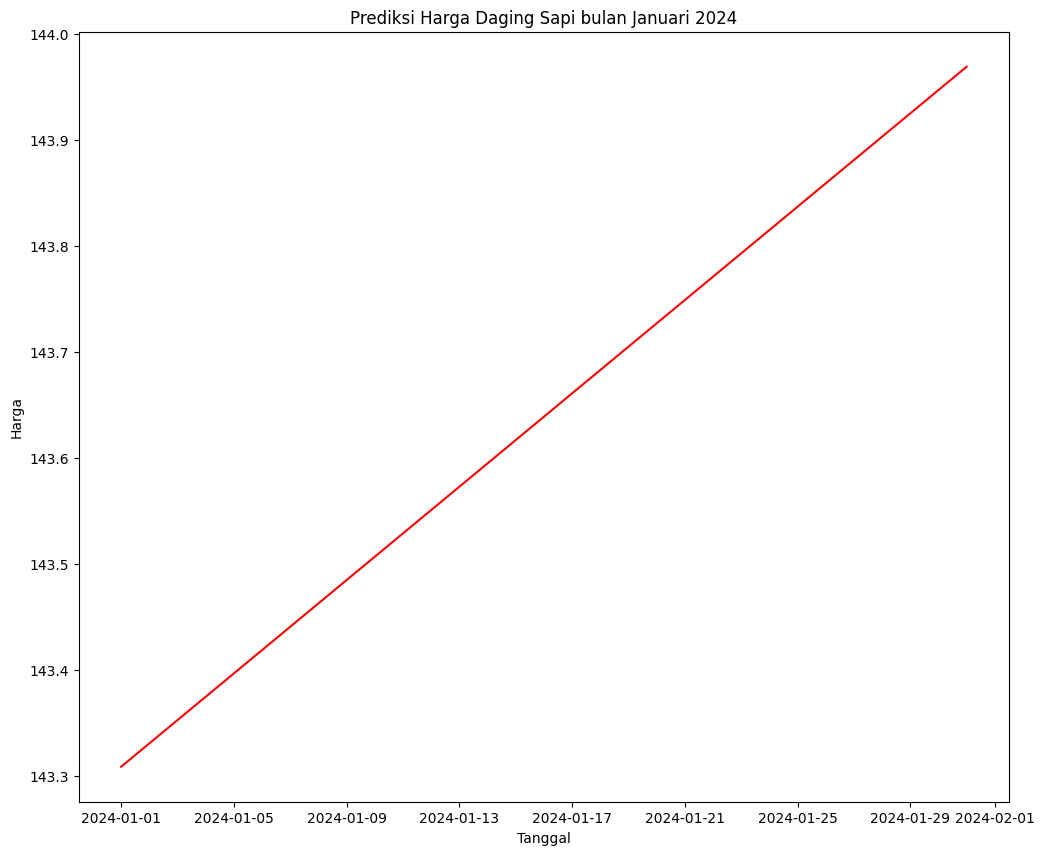

In [ ]:
dates_scale=scale.transform([[to_integer(predict_dates)[i],0] for i in range(31)])

prediksi_sapi= model.predict([[i] for i  in dates_scale[:,0]])
prediksi_hasil=scale.inverse_transform([[0,float(prediksi_sapi[i])] for i in range(31)])

plt.figure(figsize = (12,10))
plt.plot(predict_dates.date,prediksi_hasil[:,1], color= 'red')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title("Prediksi Harga Daging Sapi bulan Januari 2024")
plt.show()

In [ ]:
for i in range(day):
  print(f"{predict_dates.date[i]}: {prediksi_hasil[i,1]}" )

2024-01-01: 143.3083847293244
2024-01-02: 143.3303949446153
2024-01-03: 143.35240515990614
2024-01-04: 143.3744153751971
2024-01-05: 143.396425590488
2024-01-06: 143.41843580577896
2024-01-07: 143.44044602106976
2024-01-08: 143.4624562363607
2024-01-09: 143.48446645165166
2024-01-10: 143.50647666694258
2024-01-11: 143.5284868822334
2024-01-12: 143.55049709752433
2024-01-13: 143.57250731281528
2024-01-14: 143.5945175281061
2024-01-15: 143.61652774339706
2024-01-16: 143.63853795868798
2024-01-17: 143.6605481739789
2024-01-18: 143.68255838926976
2024-01-19: 143.70456860456068
2024-01-20: 143.72657881985162
2024-01-21: 143.74858903514252
2024-01-22: 143.77059925043338
2024-01-23: 143.79260946572433
2024-01-24: 143.81461968101524
2024-01-25: 143.83662989630608
2024-01-26: 143.858640111597
2024-01-27: 143.88065032688795
2024-01-28: 143.90266054217886
2024-01-29: 143.92467075746973
2024-01-30: 143.94668097276065
2024-01-31: 143.96869118805157


# trash code

In [ ]:
# data_ayam_=pd.read_excel("Tabel Harga Berdasarkan Daerah_2023.xlsx")
# data_ayam_=data_ayam_.drop(["No","Komoditas (Rp)"],axis=1)
# data_ayam=replace_empty(data_ayam_.iloc[7])
# data_ayam=replace_char(data_ayam)

# #tidak ada data extreme pada tahun 2023 jadi tidak perlu ada perubahan ke threshold
# visualisation(data_beras22_23,data_ayam,data_sapi,[])